In [2]:
%pip install numpy matplotlib librosa scipy soundfile scikit-learn

Note: you may need to restart the kernel to use updated packages.


/var/folders/3p/00fys0v91nv0c3gjwlnx9np00000gn/T/ipykernel_89998/2192923644.py:29: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=8000)


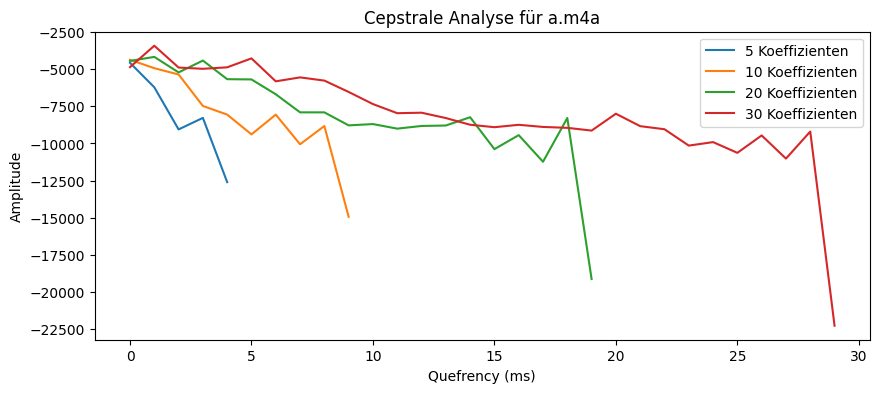

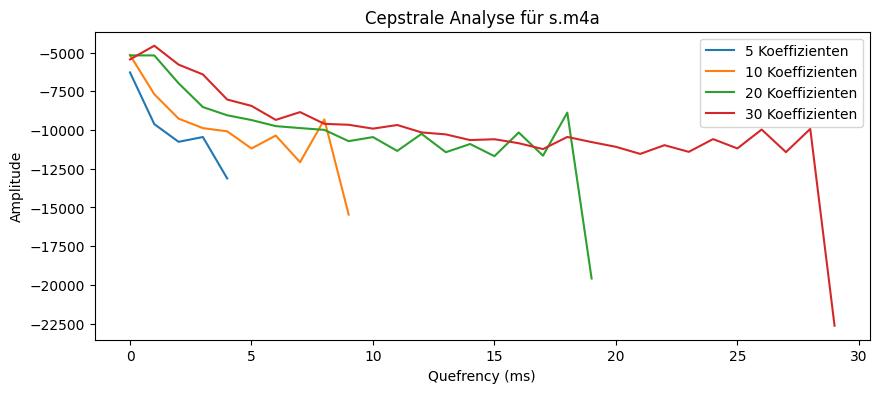

/var/folders/3p/00fys0v91nv0c3gjwlnx9np00000gn/T/ipykernel_89998/2192923644.py:51: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=8000)


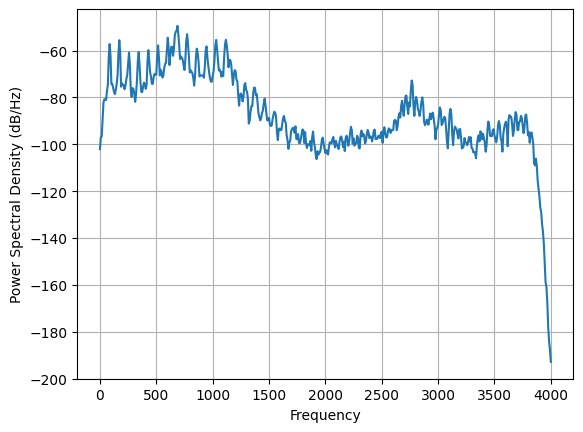

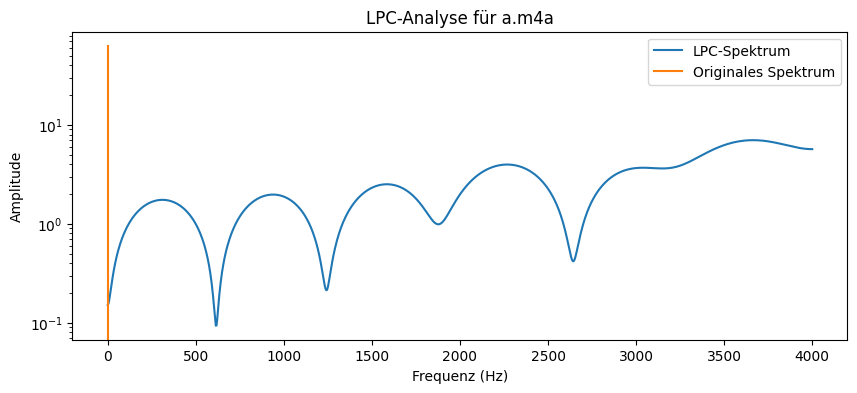

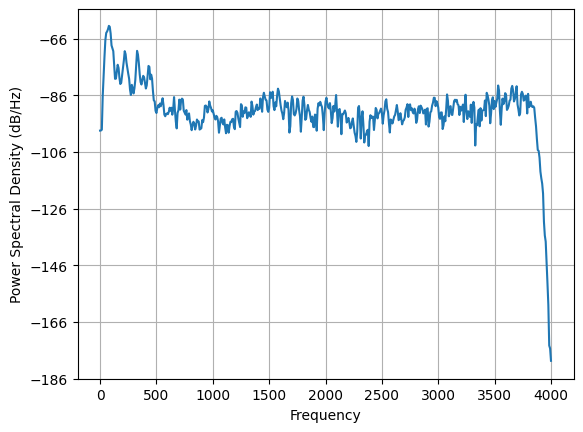

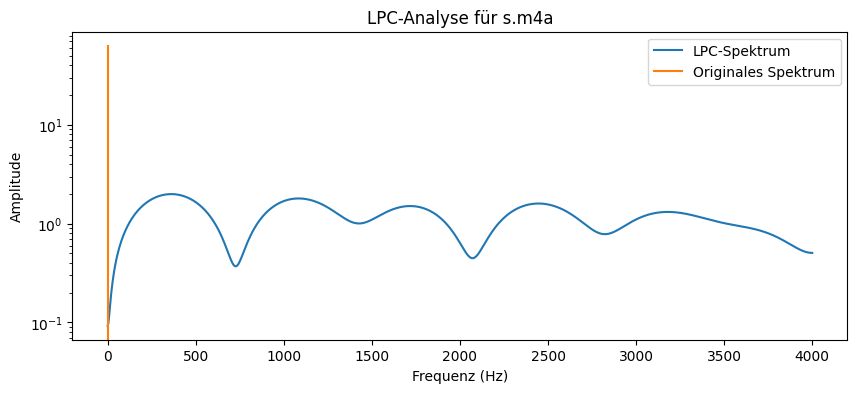

/var/folders/3p/00fys0v91nv0c3gjwlnx9np00000gn/T/ipykernel_89998/2192923644.py:72: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=8000)


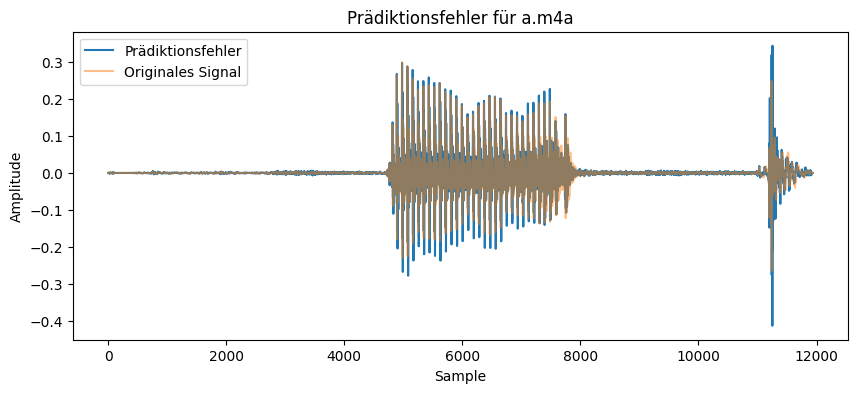

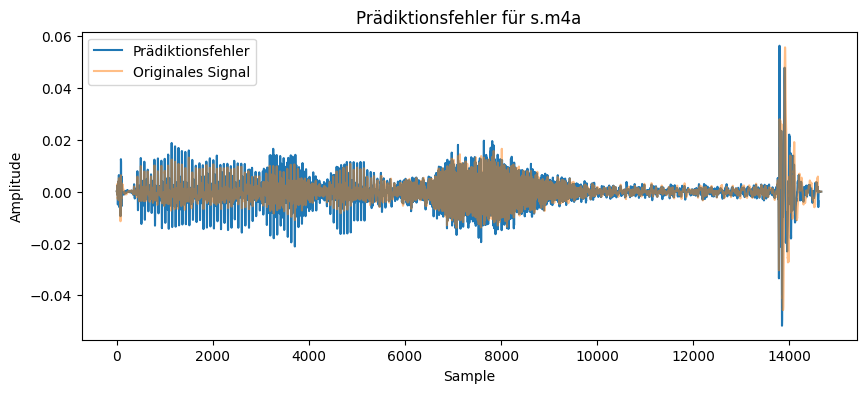

/var/folders/3p/00fys0v91nv0c3gjwlnx9np00000gn/T/ipykernel_89998/2192923644.py:91: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=8000)


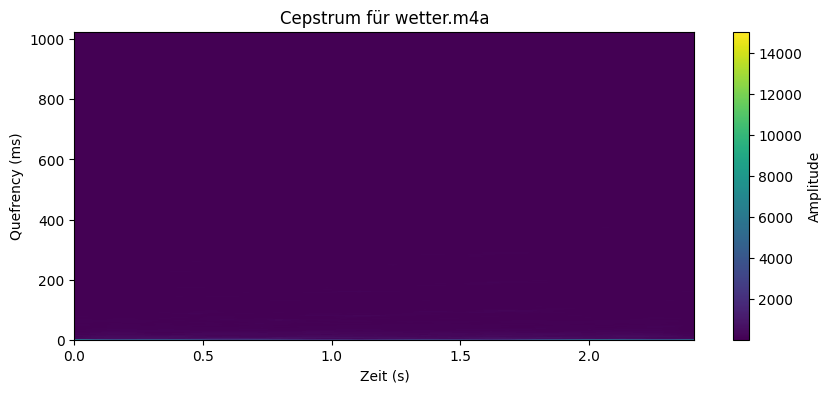

/var/folders/3p/00fys0v91nv0c3gjwlnx9np00000gn/T/ipykernel_89998/2192923644.py:109: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=8000)


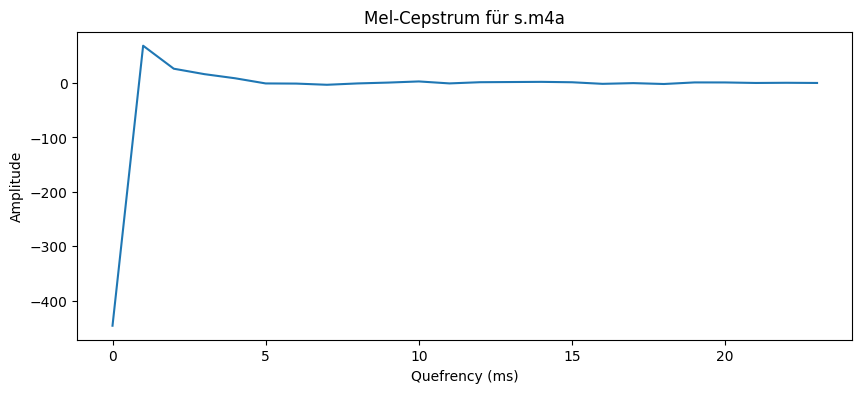

In [5]:
# Importieren notwendiger Bibliotheken
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from scipy.signal import lfilter
from scipy.signal.windows import hamming
from scipy.linalg import toeplitz

# Hilfsfunktionen für LPC
def lpc(signal, order):
    X = np.array([signal[i: i + order] for i in range(len(signal) - order)])
    y = signal[order:]
    a = np.linalg.lstsq(X, y, rcond=None)[0]
    return np.concatenate(([1], -a))

def freqz(b, a, worN=512, fs=2*np.pi):
    w = np.linspace(0, np.pi, worN)
    h = np.exp(1j * np.outer(w, np.arange(len(a)))) @ a
    return h, w * fs / (2 * np.pi)

# Dateipfade definieren
a_file = 'a.m4a'
s_file = 's.m4a'
sentence_file = 'wetter.m4a'

# a) Funktion zum Extrahieren und Plotten von Cepstral-Koeffizienten
def plot_cepstral(file_path, n_coeffs):
    y, sr = librosa.load(file_path, sr=8000)
    S = np.abs(librosa.stft(y))
    log_S = np.log(S + 1e-10)
    cepstrum = dct(log_S, axis=0)
    
    plt.figure(figsize=(10, 4))
    for n in n_coeffs:
        smoothed = idct(cepstrum[:n, :], axis=0, type=2)
        plt.plot(np.mean(smoothed, axis=1), label=f'{n} Koeffizienten')
    plt.title(f'Cepstrale Analyse für {file_path}')
    plt.xlabel('Quefrency (ms)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Cepstral-Koeffizienten für "a" und "s" mit unterschiedlichen Anzahlen von Koeffizienten plotten 
n_coeffs = [5, 10, 20, 30]
plot_cepstral(a_file, n_coeffs)
plot_cepstral(s_file, n_coeffs)

# b) Funktion zur Durchführung der LPC-Analyse und zum Plotten des Spektrums
def plot_lpc_spectrum(file_path, order):
    y, sr = librosa.load(file_path, sr=8000)
    a = lpc(y, order)
    S = np.abs(librosa.stft(y))
    f, Pxx = plt.psd(y, NFFT=1024, Fs=sr)
    H, freq = freqz(1, a, worN=1024, fs=sr)
    
    plt.figure(figsize=(10, 4))
    plt.semilogy(freq, np.abs(H), label='LPC-Spektrum')
    plt.semilogy(f, np.sqrt(Pxx), label='Originales Spektrum')
    plt.title(f'LPC-Analyse für {file_path}')
    plt.xlabel('Frequenz (Hz)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# LPC-Analyse für "a" und "s" durchführen 
plot_lpc_spectrum(a_file, order=12)
plot_lpc_spectrum(s_file, order=12)

# c) Funktion zum Plotten des Prädiktionsfehlers 
def plot_prediction_error(file_path, order):
    y, sr = librosa.load(file_path, sr=8000)
    a = lpc(y, order)
    e = lfilter(a, 1, y)
    
    plt.figure(figsize=(10, 4))
    plt.plot(e, label='Prädiktionsfehler')
    plt.plot(y, alpha=0.5, label='Originales Signal')
    plt.title(f'Prädiktionsfehler für {file_path}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Prädiktionsfehler für "a" und "s" plotten 
plot_prediction_error(a_file, order=12)
plot_prediction_error(s_file, order=12)

# d) Funktion zum Berechnen und Plotten des Cepstrums für einen Satz 
def plot_sentence_cepstrum(file_path):
    y, sr = librosa.load(file_path, sr=8000)
    S = np.abs(librosa.stft(y))
    log_S = np.log(S + 1e-10)
    cepstrum = dct(log_S, axis=0)
    
    plt.figure(figsize=(10, 4))
    plt.imshow(np.abs(cepstrum), aspect='auto', origin='lower', extent=[0, y.shape[0] / sr, 0, cepstrum.shape[0]])
    plt.title(f'Cepstrum für {file_path}')
    plt.xlabel('Zeit (s)')
    plt.ylabel('Quefrency (ms)')
    plt.colorbar(label='Amplitude')
    plt.show()

# Cepstrum für den Satz plotten 
plot_sentence_cepstrum(sentence_file)

# e) Funktion zur Erstellung einer Mel-Filterbank und Berechnung des Mel-Cepstrums 
def plot_mel_cepstrum(file_path, n_filters):
    y, sr = librosa.load(file_path, sr=8000)
    n_fft = 2048  # oder ein anderer Wert; dies sollte dem n_fft entsprechen, das in librosa.stft verwendet wird
    S = np.abs(librosa.stft(y, n_fft=n_fft))**2
    mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_filters)
    mel_S = np.dot(mel_basis, S)
    log_mel_S = np.log(mel_S + 1e-10)
    mel_cepstrum = dct(log_mel_S, axis=0)
    
    plt.figure(figsize=(10, 4))
    plt.plot(np.mean(mel_cepstrum, axis=1))
    plt.title(f'Mel-Cepstrum für {file_path}')
    plt.xlabel('Quefrency (ms)')
    plt.ylabel('Amplitude')
    plt.show()

# Mel-Cepstrum für "s" plotten 
plot_mel_cepstrum(s_file, n_filters=24)
